In [90]:
import os
from glob import glob
from PIL import Image
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras

from sklearn.model_selection import train_test_split

In [17]:
train_path = glob(os.path.join(os.getenv("HOME"), "data/rock_scissor_paper/train/*/*/*"))
test_path = glob(os.path.join(os.getenv("HOME"), "data/rock_scissor_paper/test/*/*/*"))

In [32]:
data_size = len(train_path) + len(test_path)
print(f"Total image size : {data_size}")

Total image size : 4317


In [65]:
def resize_img(img, img_size, color):
    new_img = np.reshape(img, (img_size,img_size, color))
    return new_img

In [81]:
def load_data(img_path, num_data):
    #불러올 폴더 내에 존재하는 데이터 정보
    number_of_data = num_data
    img_size = 28
    color = 3
    
    imgs = np.zeros(number_of_data*img_size*img_size*color, dtype=np.int32).reshape(number_of_data, img_size, img_size, color)
    labels = np.zeros(number_of_data, dtype = np.int32)
    
    idx=0
    for file in glob(img_path+'*/*/scissor/*'):
        img = np.array(Image.open(file),dtype=np.int32)
        img = resize_img(img, img_size, color)
        imgs[idx,:,:,:]=img   # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1
    
    for file in glob(img_path+'*/*/rock/*'):
        img = np.array(Image.open(file),dtype=np.int32)
        img = resize_img(img, img_size, color)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1
    
    for file in glob(img_path+'*/*/paper/*'):
        img = np.array(Image.open(file),dtype=np.int32)
        img = resize_img(img, img_size, color)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx = idx+1

    return imgs, labels

In [82]:
data_dir = os.getenv("HOME")+"/data/rock_scissor_paper/"
(img, label) = load_data(data_dir, data_size)

Text(0.5, 1.0, '2')

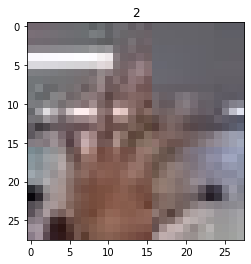

In [83]:
import matplotlib.pyplot as plt

plt.imshow(img[4300])
plt.title(label[4300], loc='center')

In [84]:
img = img/255.0

In [87]:
np.max(img), np.min(img)

(1.0, 0.0)

In [94]:
x_train, x_test, y_train, y_test = train_test_split(img, label, test_size=0.1, shuffle=True)

In [95]:
#학습 데이터의 사이즈를 확인한다.
print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

x_train shape: (3885, 28, 28, 3)
y_train shape: (3885,)


In [96]:
#test data의 shape을 확인한다.
print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

x_test shape: (432, 28, 28, 3)
y_test shape: (432,)


In [97]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28,28,3), activity_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu',activity_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 64)        1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 4803      
Total params: 43,523
Trainable params: 43,523
Non-trainable params: 0
__________________________________________________

In [98]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print("NO")
        print(e)

NO
Physical devices cannot be modified after being initialized


In [99]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [100]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs = 10, batch_size = 32, validation_split = 0.1)

Epoch 1/10
110/110 [==============================] - 5s 41ms/step - loss: 2.1886 - accuracy: 0.3830 - val_loss: 1.1498 - val_accuracy: 0.4961
Epoch 2/10
110/110 [==============================] - 0s 2ms/step - loss: 1.1080 - accuracy: 0.5506 - val_loss: 1.0842 - val_accuracy: 0.5835
Epoch 3/10
110/110 [==============================] - 0s 2ms/step - loss: 1.0579 - accuracy: 0.6053 - val_loss: 1.0180 - val_accuracy: 0.6504
Epoch 4/10
110/110 [==============================] - 0s 2ms/step - loss: 0.9662 - accuracy: 0.6931 - val_loss: 0.9002 - val_accuracy: 0.7481
Epoch 5/10
110/110 [==============================] - 0s 2ms/step - loss: 0.8482 - accuracy: 0.7666 - val_loss: 0.7909 - val_accuracy: 0.7892
Epoch 6/10
110/110 [==============================] - 0s 2ms/step - loss: 0.7455 - accuracy: 0.8118 - val_loss: 0.7175 - val_accuracy: 0.8021
Epoch 7/10
110/110 [==============================] - 0s 2ms/step - loss: 0.6582 - accuracy: 0.8412 - val_loss: 0.6305 - val_accuracy: 0.8380
Epoch

In [101]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

14/14 - 1s - loss: 0.5104 - accuracy: 0.8750
test_loss: 0.5103816390037537 
test_accuracy: 0.875


In [102]:
predicted_result = model.predict(x_test)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)
print(len(predicted_labels))
print(predicted_labels)

432
[0 1 0 1 1 2 2 1 1 1 1 0 2 1 2 0 0 0 1 2 1 2 1 1 1 2 1 0 1 1 1 0 2 2 1 1 0
 1 0 1 1 0 1 0 1 1 1 1 1 2 1 1 2 2 2 1 0 0 1 0 1 1 0 2 1 2 2 1 1 0 1 1 0 1
 1 1 1 0 1 2 2 1 1 1 1 1 1 2 0 0 1 2 0 1 2 2 0 2 0 1 0 2 1 0 2 2 0 1 2 0 1
 2 2 2 0 1 0 1 0 1 1 1 1 2 1 2 1 0 0 0 2 0 1 2 2 2 1 1 1 2 2 2 0 2 2 1 1 1
 2 0 2 0 1 0 0 1 0 2 1 0 1 0 1 1 1 1 0 0 0 2 1 0 0 2 0 2 1 2 1 1 1 1 1 2 1
 2 2 1 2 0 1 1 1 2 1 2 1 2 0 1 0 1 0 1 0 0 2 1 2 0 2 1 1 2 0 1 1 2 2 0 2 2
 1 2 0 0 0 1 1 1 2 2 0 0 1 2 1 0 0 2 1 0 0 1 2 2 1 1 1 2 0 1 1 1 2 2 0 0 1
 2 2 2 0 0 1 1 0 2 1 1 1 2 1 1 2 2 1 2 2 0 1 2 0 2 0 2 2 1 2 0 1 2 2 0 0 1
 1 1 2 0 1 1 0 2 1 2 0 1 1 0 2 2 0 0 1 0 1 0 0 0 0 0 1 0 2 0 0 0 0 2 0 1 2
 1 2 1 1 1 1 0 2 1 2 2 2 1 0 0 1 0 0 0 1 0 1 2 0 0 0 1 1 2 1 0 1 0 1 2 0 1
 0 2 1 0 1 0 0 2 1 0 1 1 1 0 2 0 0 2 1 0 2 1 2 1 0 0 1 0 2 2 0 0 2 2 2 1 0
 1 1 0 0 2 2 1 2 1 2 2 1 1 2 0 1 1 1 1 2 1 1 0 2 1]
